In [1]:
import pandas as pd
import numpy as np
import re
from experiment_utils import get_latest_files
from post_processing import series_name, violinplots_per_iteration, combined_box_violin_plots, error_estimation, merge_estimates_true, compute_val_metrics, under_over_analysis, under_over_by_method, val_metrics_per_iteration, boxplots, boxplots_per_iteration, add_weights, exponential_weights_paper

Functions

In [2]:
def clean_filename(filepath):
    filename = filepath.split('/')[-1]
    
    filename = filename.rsplit('.', 1)[0]
    
    # Check if the filename ends with a date in the format DDMMYYYY or similar
    # and remove the date if it exists
    filename = re.sub(r'_\d{8}$', '', filename)
    
    return filename

def clean_method(method_str):
    parts = method_str.split('.')
    if len(parts) > 3:
        method_name = parts[3].split()[0]
    else:
        method_name = parts[-1].split()[0]
    return method_name

## Upload Data

!TODO be carefull with "get_latest_files" when lstm results are ready

In [3]:
[get_latest_files('results/saude', 'table_A'), 
get_latest_files('results/transportes', 'table_A'), 
get_latest_files('results/eco_financas', 'table_A'), 
get_latest_files('results/eng_ciencias', 'table_A'), 
get_latest_files('results/energia', 'table_A'), 
get_latest_files('results/ambiente', 'table_A'), 
get_latest_files('results/meteorologia', 'table_A')]

['results/saude\\table_A_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_A_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv']

In [4]:
# Validation Results
saude = pd.read_csv('results/saude\\table_A_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes = pd.read_csv('results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas = pd.read_csv('results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias = pd.read_csv('results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia = pd.read_csv('results/energia\\table_A_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente = pd.read_csv('results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia = pd.read_csv('results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

val_dict = {'saude': saude,
 'transportes': transportes,
 'eco_financas':eco_financas,
 'eng_ciencias': eng_ciencias,
 'energia': energia,
 'ambiente': ambiente,
 'meteorologia': meteorologia
 }

In [5]:
real_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,1122.564394,20.017677,33.504692
1,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1097.670935,20.360957,33.131117
2,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,197.821429,8.396104,14.064901
3,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,4652.950871,64.066829,68.212542
4,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...,...
2725,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,47.402579,5.636406,6.884953
2726,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,63.853138,5.510571,7.990816
2727,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,52.510323,5.949948,7.246401
2728,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,74.284770,6.082853,8.618861


In [6]:
[get_latest_files('results/saude', 'table_B'), 
get_latest_files('results/transportes', 'table_B'), 
get_latest_files('results/eco_financas', 'table_B'), 
get_latest_files('results/eng_ciencias', 'table_B'), 
get_latest_files('results/energia', 'table_B'), 
get_latest_files('results/ambiente', 'table_B'), 
get_latest_files('results/meteorologia', 'table_B')]

['results/saude\\table_B_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_B_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv']

In [7]:
# Test Results
saude_test = pd.read_csv('results/saude\\table_B_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes_test = pd.read_csv('results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas_test = pd.read_csv('results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias_test = pd.read_csv('results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia_test = pd.read_csv('results/energia\\table_B_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente_test = pd.read_csv('results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia_test = pd.read_csv('results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

test_dict = {'saude': saude_test,
 'transportes': transportes_test,
 'eco_financas':eco_financas_test,
 'eng_ciencias': eng_ciencias_test,
 'energia': energia_test,
 'ambiente': ambiente_test,
 'meteorologia': meteorologia_test
 }

In [8]:
real_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,Tree,17.316252,2.493517,4.161280
1,saude,datasets/processed_data/covid19_17052024.csv,0,ARMA,35.113134,5.037637,5.925634
2,saude,datasets/processed_data/covid19_17052024.csv,1,Tree,5.463435,1.555446,2.337399
3,saude,datasets/processed_data/covid19_17052024.csv,1,ARMA,14.434002,3.375995,3.799211
4,saude,datasets/processed_data/covid19_17052024.csv,2,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...,...
65,meteorologia,datasets/processed_data/jena_climate_data.csv,12,ARMA,23783.710487,4.231992,154.219683
66,meteorologia,datasets/processed_data/jena_climate_data.csv,13,Tree,6025.325689,40.736198,77.622971
67,meteorologia,datasets/processed_data/jena_climate_data.csv,13,ARMA,7167.891640,68.984216,84.663402
68,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,Tree,10.731559,1.387957,3.275906


# Real Data

## Saúde

In [9]:
real_data_val['filename'] = real_data_val['filename'].apply(clean_filename)
real_data_val['method'] = real_data_val['method'].apply(clean_method)
real_data_val = series_name(real_data_val)
real_data_val

,series,Field,method,iteration,model,mse,mae,rmse
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...
2725,MLTempDataset_0,meteorologia,MarkovCV,7,ARMA,47.402579,5.636406,6.884953
2726,MLTempDataset_0,meteorologia,MarkovCV,8,Tree,63.853138,5.510571,7.990816
2727,MLTempDataset_0,meteorologia,MarkovCV,8,ARMA,52.510323,5.949948,7.246401
2728,MLTempDataset_0,meteorologia,MarkovCV,9,Tree,74.284770,6.082853,8.618861


In [10]:
real_data_test['filename'] = real_data_test['filename'].apply(clean_filename)
real_data_test = series_name(real_data_test)
real_data_test

,series,Field,model,mse,mae,rmse
0,covid19_0,saude,Tree,17.316252,2.493517,4.161280
1,covid19_0,saude,ARMA,35.113134,5.037637,5.925634
2,covid19_1,saude,Tree,5.463435,1.555446,2.337399
3,covid19_1,saude,ARMA,14.434002,3.375995,3.799211
4,covid19_2,saude,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...
65,jena_climate_data_12,meteorologia,ARMA,23783.710487,4.231992,154.219683
66,jena_climate_data_13,meteorologia,Tree,6025.325689,40.736198,77.622971
67,jena_climate_data_13,meteorologia,ARMA,7167.891640,68.984216,84.663402
68,MLTempDataset_0,meteorologia,Tree,10.731559,1.387957,3.275906


In [11]:
real_data_val = add_weights(real_data_val,preq_methods = ['Growing_Window', 'Rolling_Window'], CV_methods = ['Block_CV'])
real_data_val

,series,Field,method,iteration,model,mse,mae,rmse,weights
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692,1.000000
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117,1.000000
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901,1.000000
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542,1.000000
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521,1.000000
...,...,...,...,...,...,...,...,...,...
30547,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,3,ARMA,37.253910,5.738725,6.103598,0.266667
30548,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,Tree,17.250183,2.400754,4.153334,0.066667
30549,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,ARMA,90.979230,7.153370,9.538303,0.066667
30550,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,2,Tree,15.219104,2.088351,3.901167,0.133333


In [12]:
est_real_data_val = error_estimation(real_data_val)

In [13]:
estimates = merge_estimates_true(est_real_data_val, real_data_test)
estimates

,series,method,model,mse_estimate,mae_estimate,Field,mse_true,mae_true,rmse
0,DailyDelhiClimate_0,AdaptedhvBlockCV,ARMA,80.749119,7.123344,meteorologia,38.297620,4.821778,6.188507
1,DailyDelhiClimate_0,AdaptedhvBlockCV,Tree,5.906699,1.836843,meteorologia,5.927350,1.839508,2.434615
2,DailyDelhiClimate_0,Block_CV,ARMA,80.503973,7.126233,meteorologia,38.297620,4.821778,6.188507
3,DailyDelhiClimate_0,Block_CV,Tree,5.770700,1.850585,meteorologia,5.927350,1.839508,2.434615
4,DailyDelhiClimate_0,Block_CV_with_weights,ARMA,70.206565,6.978417,meteorologia,38.297620,4.821778,6.188507
...,...,...,...,...,...,...,...,...,...
5891,traffic_2,Repeated_Holdout,Tree,86.013504,5.127104,transportes,74.133196,5.250257,8.610064
5892,traffic_2,Rolling_Window,ARMA,124.217230,6.575690,transportes,131.889773,7.789359,11.484327
5893,traffic_2,Rolling_Window,Tree,77.258662,4.932268,transportes,74.133196,5.250257,8.610064
5894,traffic_2,Rolling_Window_with_weights,ARMA,136.505696,6.756850,transportes,131.889773,7.789359,11.484327


In [14]:
all_metrics = compute_val_metrics(estimates, 'mse')
all_metrics

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,method,model,metric
0,-5.433608e+04,-1.018647e-08,-9.248379,21.211298,-1.144028e+07,1.155448e+07,1.235702e+06,AdaptedhvBlockCV,ARMA,PAE
1,1.643869e+05,1.557018e+01,0.275742,313.267122,2.061709e-08,1.155448e+07,1.225924e+06,AdaptedhvBlockCV,ARMA,APAE
2,8.399858e-01,2.647597e-03,-0.217666,0.674698,-9.998897e-01,2.154360e+01,2.790535e+00,AdaptedhvBlockCV,ARMA,RPAE
3,1.131530e+00,3.192090e-01,0.124873,0.806448,2.307294e-03,2.154360e+01,2.685573e+00,AdaptedhvBlockCV,ARMA,RAPAE
4,1.063404e-01,2.631870e-03,-0.244249,0.504504,-1.999559e+00,1.830102e+00,7.108546e-01,AdaptedhvBlockCV,ARMA,sMPAE
...,...,...,...,...,...,...,...,...,...,...
105,2.374848e+04,1.007932e-02,-0.116593,26.387536,-6.238061e+05,4.501483e+06,2.969090e+05,Rolling_Window_with_weights,Tree,PAE
106,3.201758e+04,4.571309e+00,0.041059,132.920894,5.523761e-09,4.501483e+06,2.961314e+05,Rolling_Window_with_weights,Tree,APAE
107,9.972147e+06,9.459921e-02,-0.059811,2.031860,-9.999716e-01,2.672519e+09,1.629452e+08,Rolling_Window_with_weights,Tree,RPAE
108,9.972147e+06,3.693153e-01,0.070694,2.031860,9.662739e-04,2.672519e+09,1.629452e+08,Rolling_Window_with_weights,Tree,RAPAE


In [15]:
all_metrics[(all_metrics['model']=='ARMA') & (all_metrics['metric']=='sMPAE') ]

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,method,model,metric
4,0.106340,0.002632,-0.244249,0.504504,-1.999559,1.830102,0.710855,AdaptedhvBlockCV,ARMA,sMPAE
14,0.105428,0.002579,-0.245769,0.504214,-1.999559,1.831155,0.711018,Block_CV,ARMA,sMPAE
24,0.070031,-0.009952,-0.182414,0.404655,-1.999560,1.887220,0.661395,Block_CV_with_weights,ARMA,sMPAE
34,0.073931,-0.003723,-0.181670,0.401573,-1.999562,1.880906,0.662738,Block_CV_with_weights_paper,ARMA,sMPAE
44,0.091602,-0.007571,-0.223474,0.473120,-1.999561,1.809280,0.715252,Growing_Window,ARMA,sMPAE
54,0.081763,-0.001426,-0.197256,0.407156,-1.999559,1.877322,0.684803,Growing_Window_with_weights,ARMA,sMPAE
64,0.010210,-0.019181,-0.259991,0.303543,-1.999565,1.876011,0.688927,Holdout,ARMA,sMPAE
74,0.054604,-0.006552,-0.271832,0.476338,-1.999559,1.823455,0.711778,MarkovCV,ARMA,sMPAE
84,0.005131,-0.024771,-0.288766,0.295462,-1.999555,1.958727,0.695327,Repeated_Holdout,ARMA,sMPAE
94,0.090809,-0.007213,-0.203245,0.477566,-1.999561,1.825201,0.722998,Rolling_Window,ARMA,sMPAE


In [16]:
under_over_analysis(estimates, 'mse')

(             Mean    Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -218722.969059 -9.567709   -208.844791     -0.042103 -1.144028e+07   
 1   218722.969059  9.567709      0.042103    208.844791  4.099003e-08   
 2       -0.291544 -0.218193     -0.419208     -0.083621 -9.998897e-01   
 3        0.291544  0.218193      0.083621      0.419208  2.307294e-03   
 4    -9327.162118 -4.148268    -80.991599     -0.001293 -7.023322e+05   
 ..            ...       ...           ...           ...           ...   
 83       0.289531  0.176816      0.071158      0.440175  1.886088e-03   
 84  -11192.522591 -3.272943    -41.582172     -0.027188 -6.238061e+05   
 85   11192.522591  3.272943      0.027188     41.582172  5.523761e-09   
 86      -0.250228 -0.153635     -0.361236     -0.048011 -9.999716e-01   
 87       0.250228  0.153635      0.048011      0.361236  9.662739e-04   
 
          Maximum  Standard_deviation    N      %                       method  \
 0  -4.099003e-08        1.4

In [17]:
under_over_by_method(estimates, 'mse')

(             Mean     Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -114812.267870  -5.479489    -99.096697     -0.003718 -1.144028e+07   
 1   114812.267870   5.479489      0.003718     99.096697  4.099003e-08   
 2       -0.291332  -0.212645     -0.414107     -0.071942 -9.999709e-01   
 3        0.291332   0.212645      0.071942      0.414107  1.170280e-03   
 4  -114123.665650  -6.668913    -94.953504     -0.004632 -1.143580e+07   
 5   114123.665650   6.668913      0.004632     94.953504  4.373907e-08   
 6       -0.288347  -0.193704     -0.407933     -0.069610 -9.999708e-01   
 7        0.288347   0.193704      0.069610      0.407933  1.352814e-03   
 8   -65380.545566  -3.844774   -101.263989     -0.019662 -1.041102e+07   
 9    65380.545566   3.844774      0.019662    101.263989  4.543140e-10   
 10      -0.268624  -0.158496     -0.393251     -0.056072 -9.999713e-01   
 11       0.268624   0.158496      0.056072      0.393251  4.520206e-04   
 12  -68678.484728  -4.57

In [18]:
iteration_data = pd.merge(left=real_data_val, right=real_data_test, on=["model", "series"], suffixes=["_estimate", "_true"]);

In [19]:
real_data_val.method.unique()

array(['Holdout', 'Repeated_Holdout', 'Growing_Window', 'Rolling_Window',
       'Block_CV', 'AdaptedhvBlockCV', 'MarkovCV',
       'Block_CV_with_weights_paper', 'Block_CV_with_weights',
       'Growing_Window_with_weights', 'Rolling_Window_with_weights'],
      dtype=object)

In [20]:
metrics = val_metrics_per_iteration(iteration_data, 'mse', methods_list=['Block_CV_with_weights', 'Block_CV'])
metrics

method model iteration            PAE                \
                                                    mean        median   
0                Block_CV  ARMA         0  -69045.600512  3.343253e-09   
1                Block_CV  ARMA         1 -192123.670995 -1.265798e-05   
2                Block_CV  ARMA         2 -221820.542287 -5.815741e-06   
3                Block_CV  ARMA         3  391532.370607 -2.185165e-06   
4                Block_CV  ARMA         4 -180605.830918 -1.687389e-06   
5                Block_CV  Tree         0    -201.980196 -1.206874e-05   
6                Block_CV  Tree         1   -6465.695919 -1.611041e-05   
7                Block_CV  Tree         2   -3410.263314 -4.860910e-07   
8                Block_CV  Tree         3   15139.304439 -9.544171e-07   
9                Block_CV  Tree         4   -5980.025983 -5.564862e-08   
10  Block_CV_with_weights  ARMA         1 -192123.670995 -1.265798e-05   
11  Block_CV_with_weights  ARMA         2 -221820.542287 -5.815741e-06   
12  Block_CV_with_weights  ARMA         3  391532.370607 -2.185165e-06   
13  Block_CV_with_weights  ARMA         4 -180605.830918 -1.687389e-06   
14  Block_CV_with_weights  Tree         1   -6465.695919 -1.611041e-05   
15  Block_CV_with_weights  Tree         2   -3410.263314 -4.860910e-07   
16  Block_CV_with_weights  Tree         3   15139.304439 -9.544171e-07   
17  Block_CV_with_weights  Tree         4   -5980.025983 -5.564862e-08   

                                                       APAE             ...  \
             min           max           std           mean     median  ...   
0  -3.827297e+07  3.675029e+07  3.424511e+06  400223.327168  21.314314  ...   
1  -3.851710e+07  1.321823e+07  2.670828e+06  291786.969485  14.684595  ...   
2  -3.685860e+07  1.857112e+06  2.548486e+06  239917.439199  12.403180  ...   
3  -1.815110e+06  7.660159e+07  4.791290e+06  411575.624322   7.549466  ...   
4  -2.013193e+07  3.212095e+06  1.748343e+06  206992.265159  13.070432  ...   
5  -1.063718e+06  1.231192e+06  1.134965e+05   16417.089477   4.349960  ...   
6  -7.488521e+05  1.994141e+05  6.175217e+04    8994.773447   4.844006  ...   
7  -3.999467e+05  1.085788e+05  3.906912e+04    5886.806506   3.453258  ...   
8  -1.036149e+06  2.652947e+06  2.300178e+05   27306.691008   4.221070  ...   
9  -9.779661e+05  5.912710e+04  6.677724e+04    7992.253106   3.124441  ...   
10 -3.851710e+07  1.321823e+07  2.670828e+06  291786.969485  14.684595  ...   
11 -3.685860e+07  1.857112e+06  2.548486e+06  239917.439199  12.403180  ...   
12 -1.815110e+06  7.660159e+07  4.791290e+06  411575.624322   7.549466  ...   
13 -2.013193e+07  3.212095e+06  1.748343e+06  206992.265159  13.070432  ...   
14 -7.488521e+05  1.994141e+05  6.175217e+04    8994.773447   4.844006  ...   
15 -3.999467e+05  1.085788e+05  3.906912e+04    5886.806506   3.453258  ...   
16 -1.036149e+06  2.652947e+06  2.300178e+05   27306.691008   4.221070  ...   
17 -9.779661e+05  5.912710e+04  6.677724e+04    7992.253106   3.124441  ...   

           RPAE                                                        RAPAE  \
           mean    median       min           max           std         mean   
0      1.378819  0.001567 -0.999894  7.484983e+01      6.775426     1.796267   
1      0.479398 -0.083894 -0.999897  2.285743e+01      2.224930     0.915646   
2      0.621909 -0.048591 -0.999894  3.155692e+01      2.802723     1.048409   
3      0.741380 -0.027706 -0.999894  5.402977e+01      4.450140     1.113571   
4      0.908723 -0.039256 -0.999890  5.080857e+01      5.132965     1.288275   
5      4.435561 -0.071733 -0.999970  2.895870e+02     25.804346     4.942723   
6   5053.919705 -0.060622 -0.999995  1.354201e+06  82720.946317  5054.435523   
7     12.935801 -0.019719 -0.999991  9.570389e+02     92.810286    13.333749   
8   5054.995990 -0.027233 -0.999971  1.354201e+06  82720.883187  5055.419954   
9      1.006222 -0.003951 -0.999972  4.684521e+01      4.606524     1.305701 

In [21]:
metrics[metrics['model']=='Tree'].T

5              6              7   \
method                  Block_CV       Block_CV       Block_CV   
model                       Tree           Tree           Tree   
iteration                      0              1              2   
PAE       mean       -201.980196   -6465.695919   -3410.263314   
          median       -0.000012      -0.000016           -0.0   
          min    -1063718.350242 -748852.100242 -399946.668552   
          max     1231192.305918  199414.105076  108578.802846   
          std      113496.533424   61752.172175   39069.120117   
APAE      mean      16417.089477    8994.773447    5886.806506   
          median         4.34996       4.844006       3.453258   
          min                0.0            0.0            0.0   
          max     1231192.305918  748852.100242  399946.668552   
          std      112298.592066   61433.570611   38772.223528   
RPAE      mean          4.435561    5053.919705      12.935801   
          median       -0.071733      -0.060622      -0.019719   
          min           -0.99997      -0.999995      -0.999991   
          max         289.587027  1354201.18403     957.038864   
          std          25.804346   82720.946317      92.810286   
RAPAE     mean          4.942723    5054.435523      13.333749   
          median        0.434529       0.373642       0.316626   
          min            0.00009       0.000034       0.001435   
          max         289.587027  1354201.18403     957.038864   
          std          25.711673   82720.914683       92.75374   

                              8              9                      14  \
method                  Block_CV       Block_CV  Block_CV_with_weights   
model                       Tree           Tree                   Tree   
iteration                      3              4                      1   
PAE       mean      15139.304439   -5980.025983           -6465.695919   
          median       -0.000001           -0.0              -0.000016   
          min    -1036148.794686 -977966.053416         -748852.100242   
          max     2652947.295493   59127.103775          199414.105076   
          std      230017.788278   66777.239255           61752.172175   
APAE      mean      27306.691008    7992.253106            8994.773447   
          median         4.22107       3.124441               4.844006   
          min                0.0            0.0                    0.0   
          max     2652947.295493  977966.053416          748852.100242   
          std      228888.164382   66565.599092           61433.570611   
RPAE      mean        5054.99599       1.006222            5053.919705   
          median       -0.027233      -0.003951              -0.060622   
          min          -0.999971      -0.999972              -0.999995   
          max     1354201.220436      46.845211          1354201.18403   
          std       82720.883187       4.606524           82720.946317   
RAPAE     mean       5055.419954       1.305701            5054.435523   
          median        0.328054       0.262471               0.373642   
          min           0.000397       0.001688               0.000034   
          max     1354201.220436      46.845211          1354201.18403   
          std       82720.857181       4.530463           82720.914683   

                                     15                     16  \
method            Block_CV_with_weights  Block_CV_with_weights   
model                              Tree                   Tree   
iteration                             2                      3   
PAE       mean             -3410.263314           15139.304439   
          median                   -0.0              -0.000001   
          min            -399946.668552        -1036148.794686   
          max             108578.802846         2652947.295493   
          std              39069.120117          230017.788278   
APAE      mean              5886.806506           27306.691008   
        

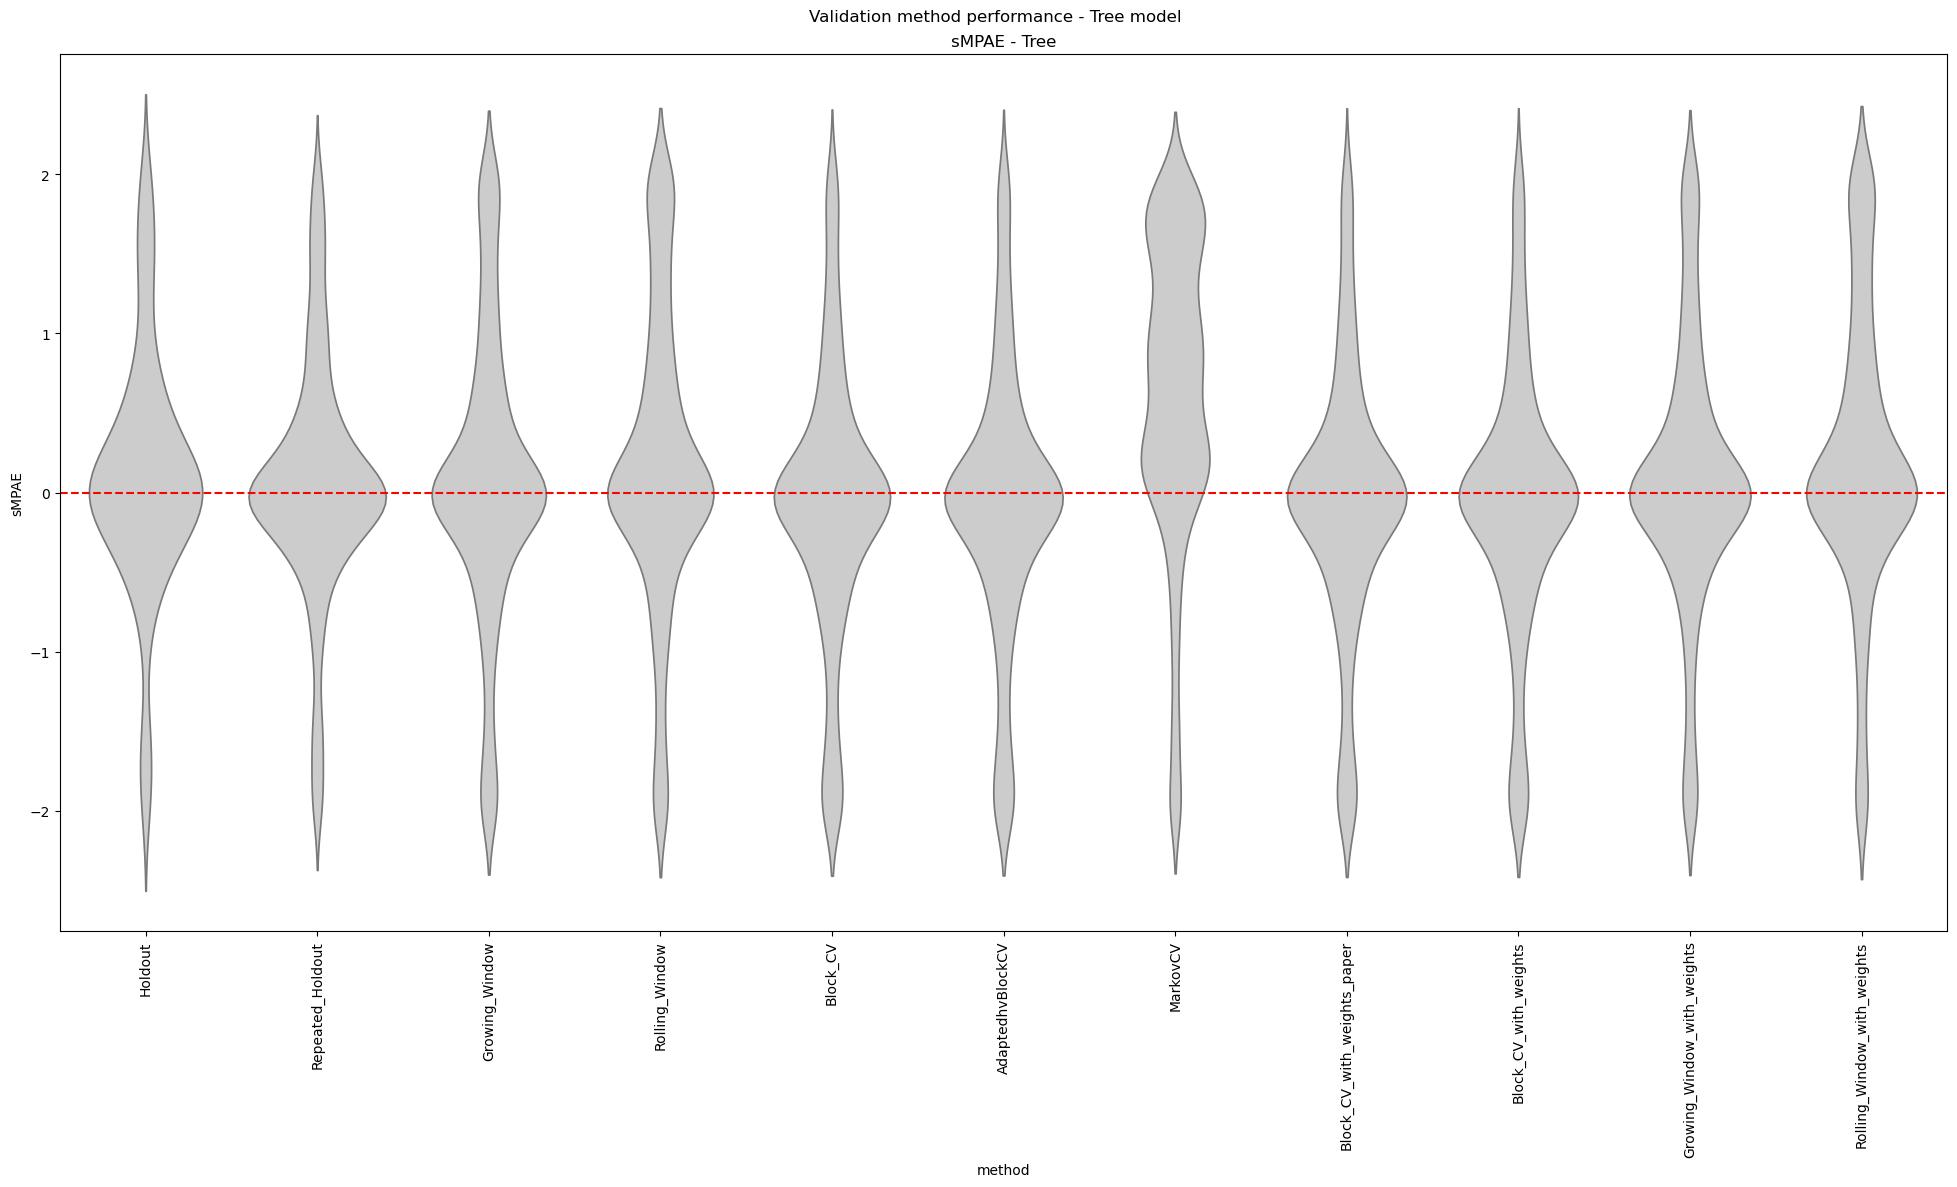

In [22]:
methods = ['Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
combined_box_violin_plots(iteration_data, "mse", "Tree", ["sMPAE"], 10, 20)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


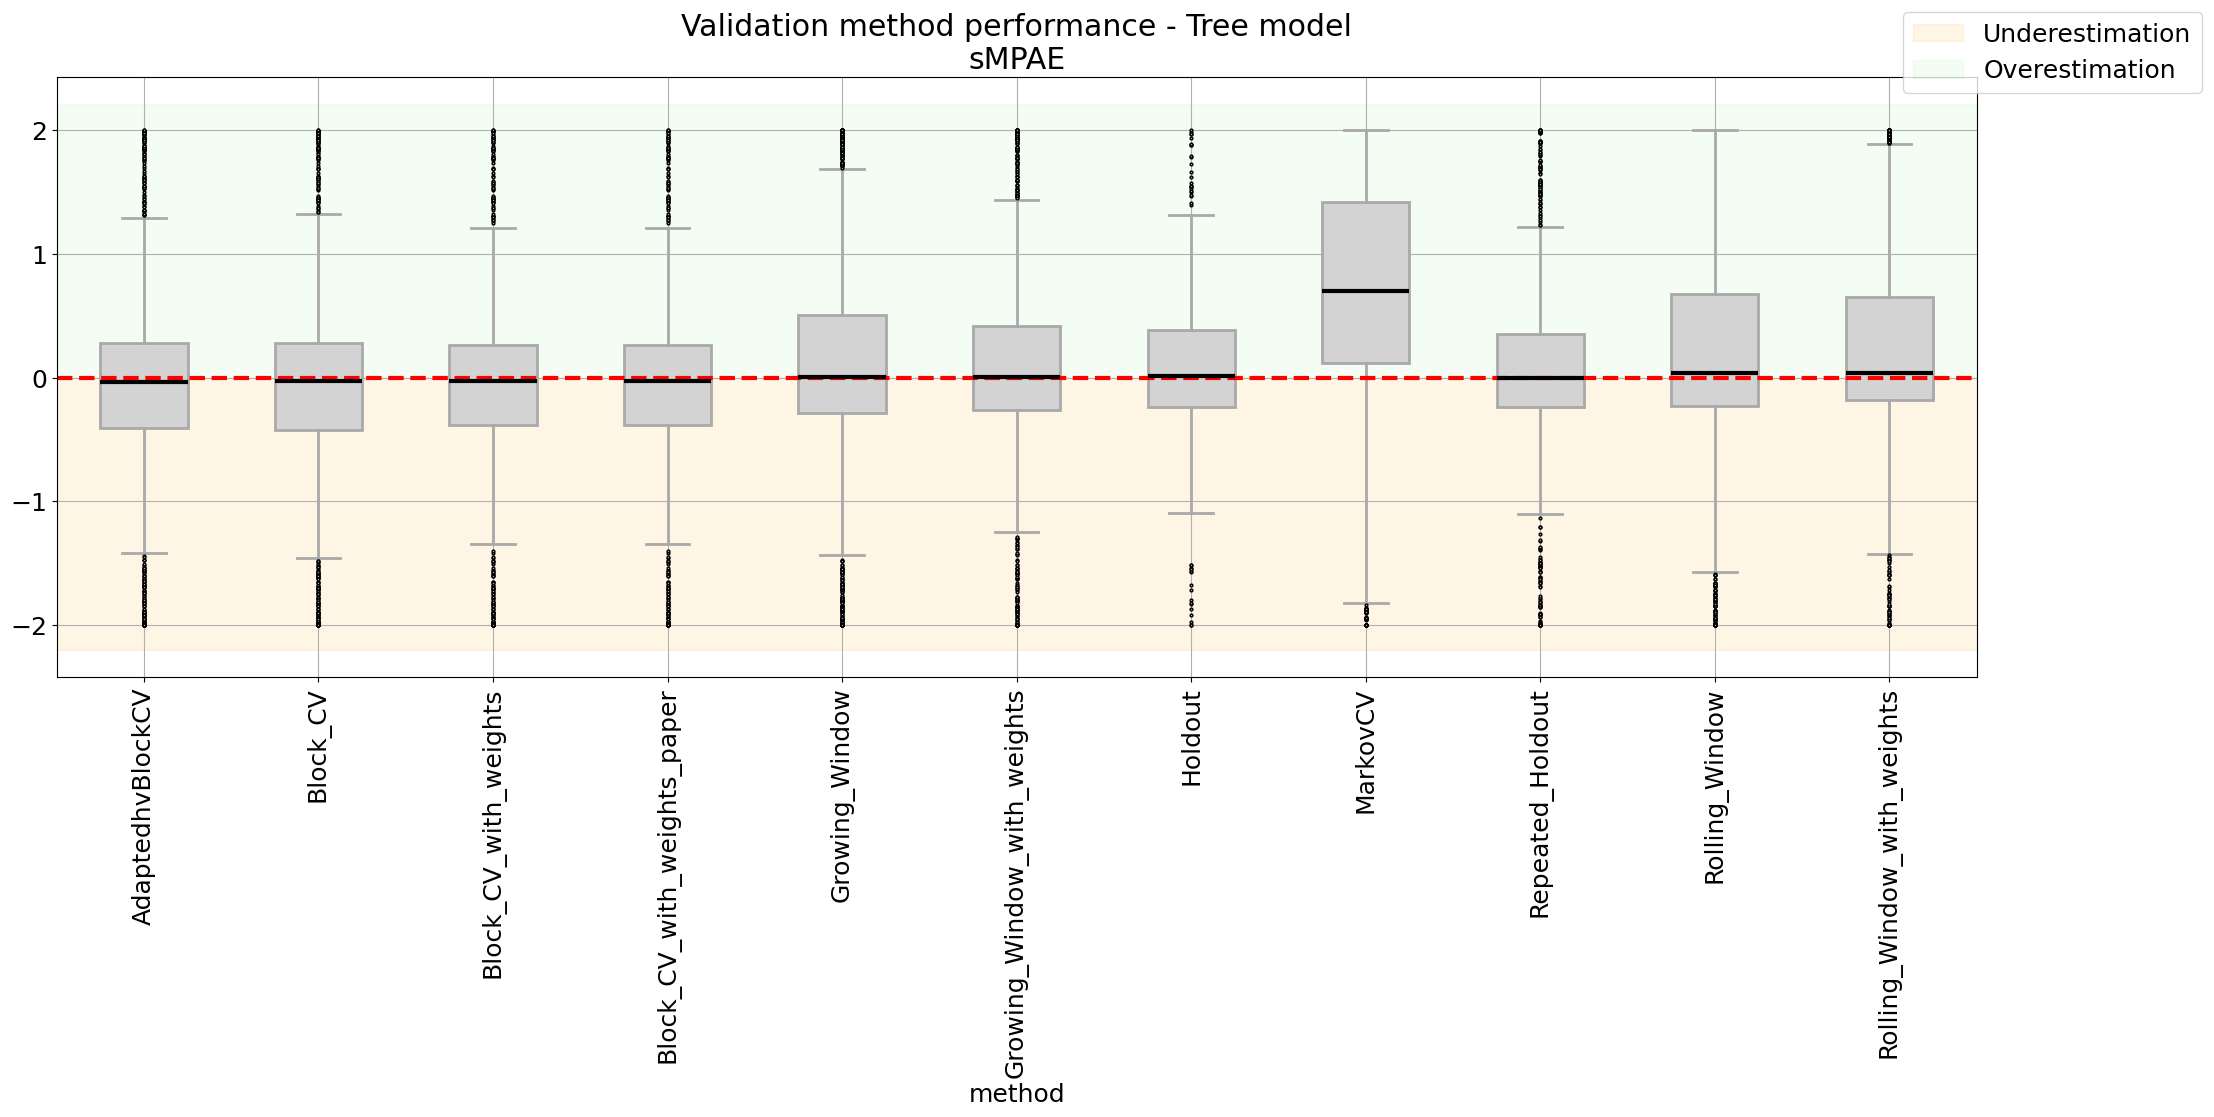

In [32]:
import matplotlib.pyplot as plt
boxplots(iteration_data, "mse", "Tree", ["sMPAE"], 8, 24, shows_outliers=True)

In [24]:
iteration_data.method.unique()

array(['Holdout', 'Repeated_Holdout', 'Growing_Window', 'Rolling_Window',
       'Block_CV', 'AdaptedhvBlockCV', 'MarkovCV',
       'Block_CV_with_weights_paper', 'Block_CV_with_weights',
       'Growing_Window_with_weights', 'Rolling_Window_with_weights'],
      dtype=object)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


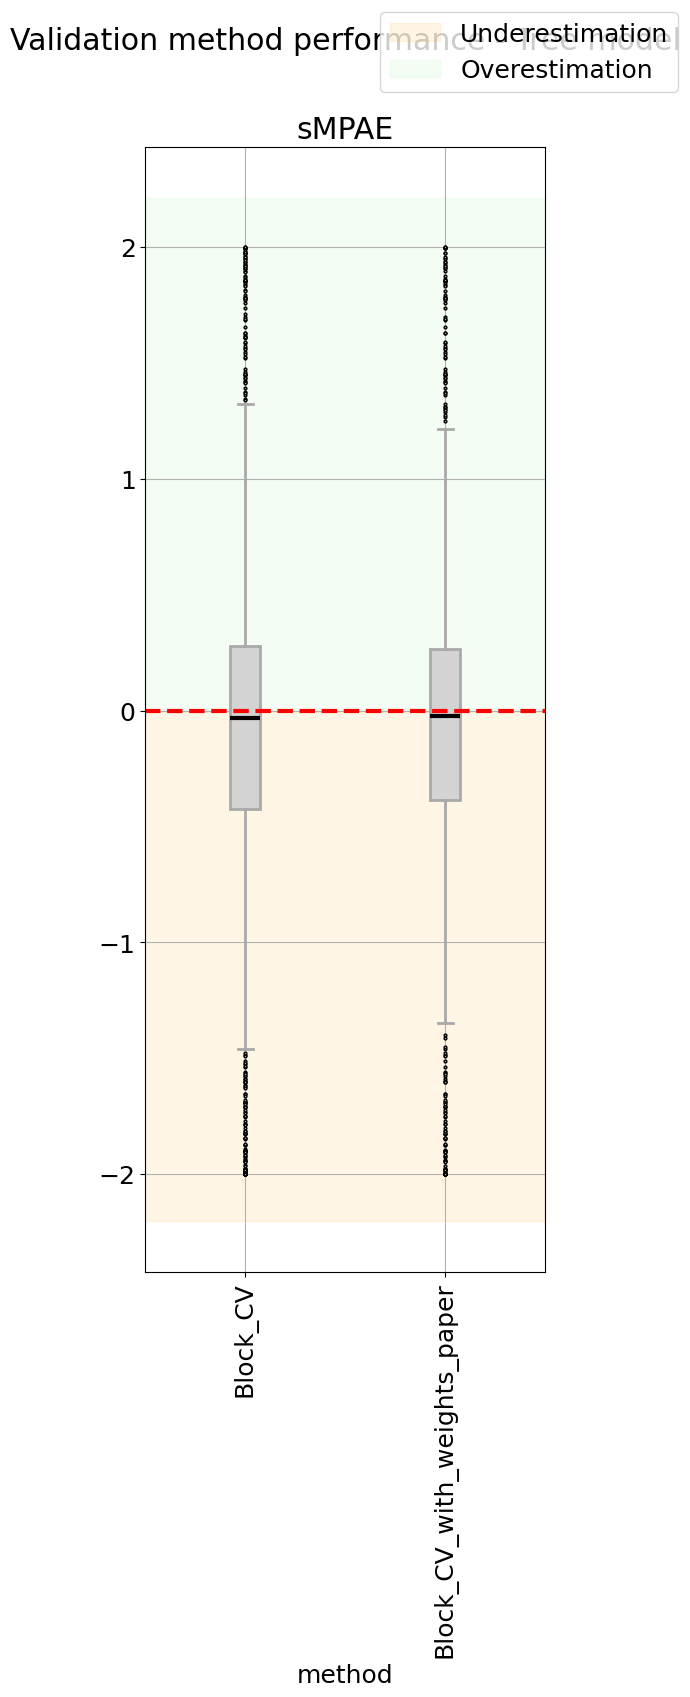

In [25]:
methods = ['Block_CV', 'Block_CV_with_weights_paper']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(it, "mse", "Tree", ["sMPAE"], 15, 5, shows_outliers=True)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


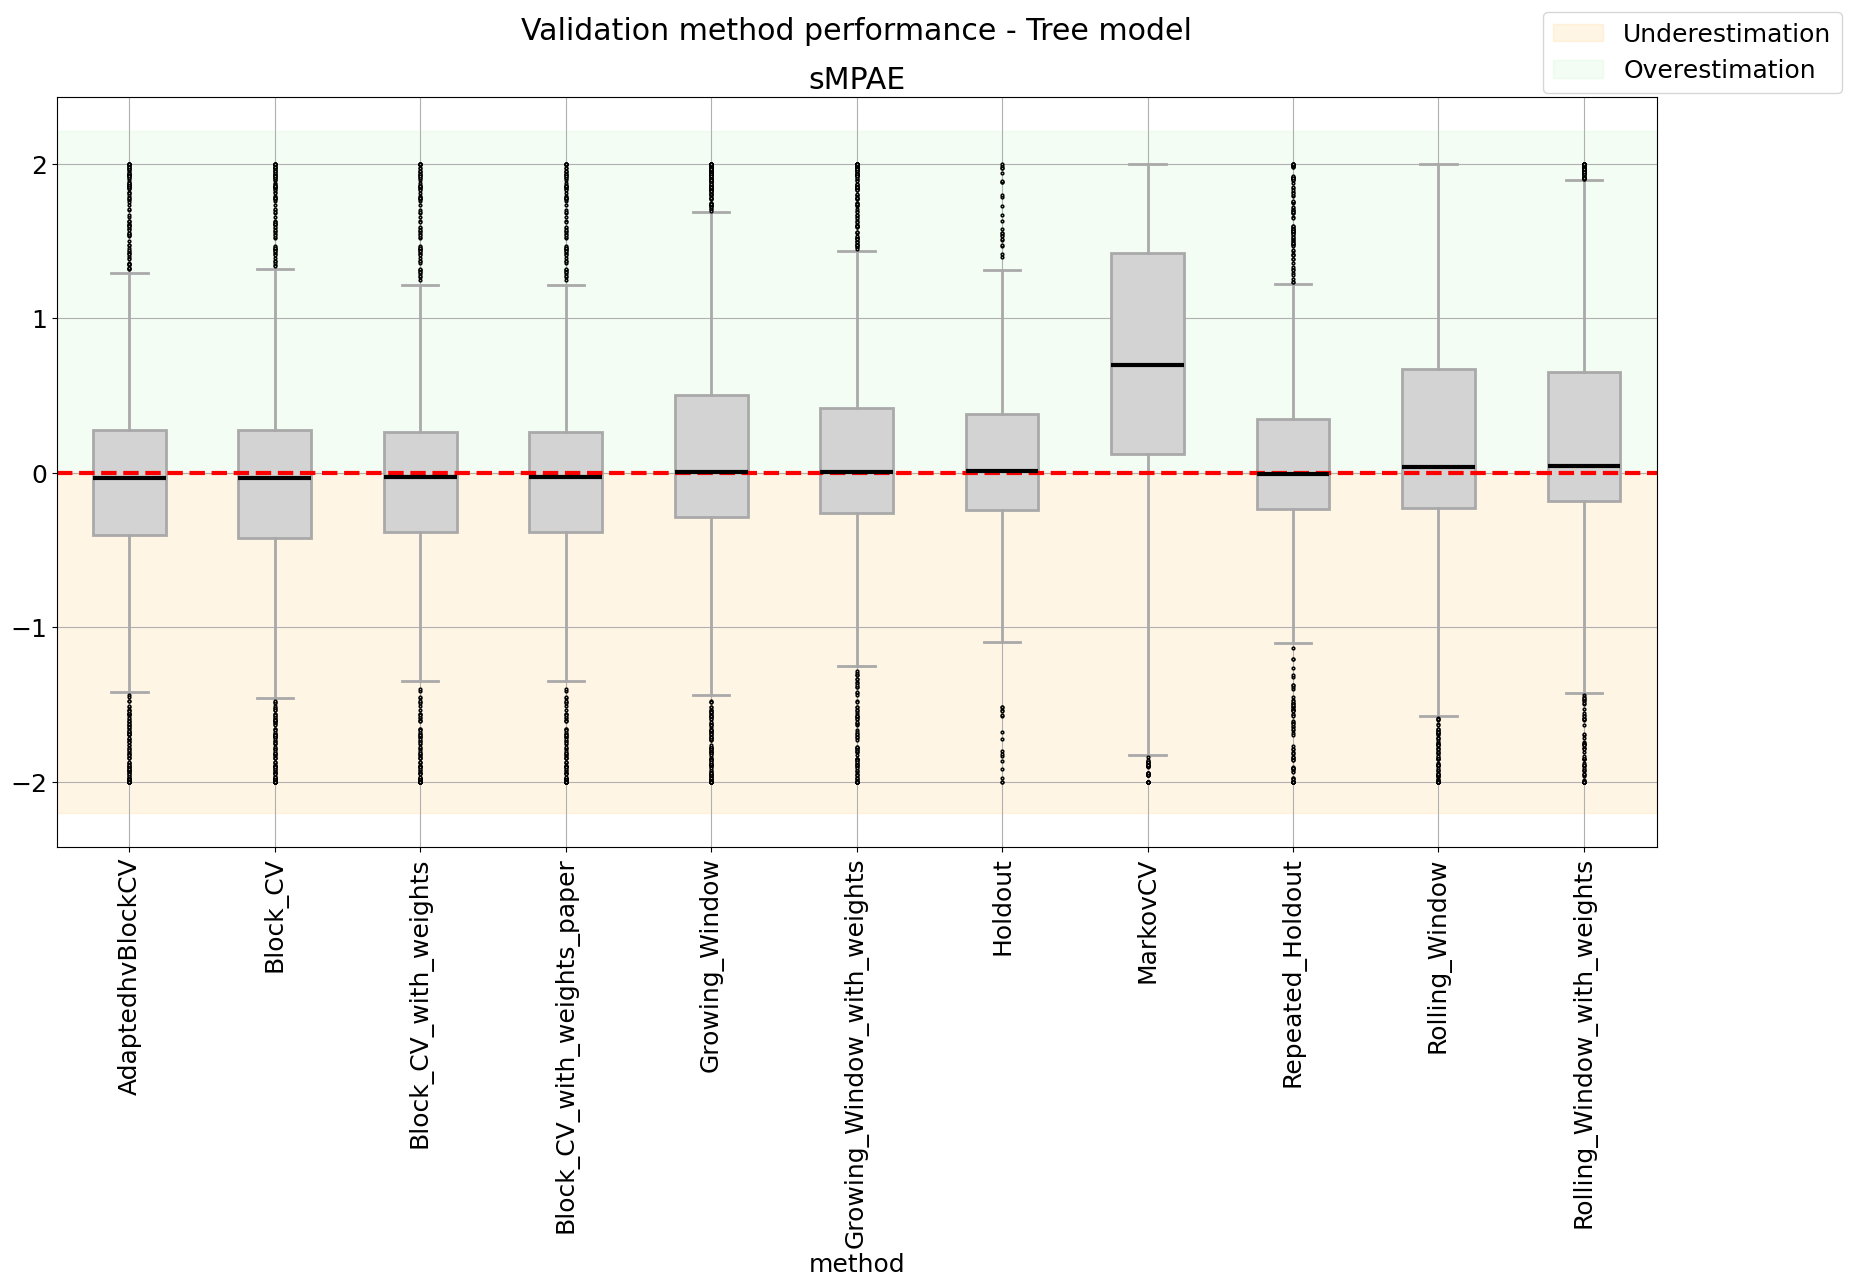

In [26]:
methods = ['Holdout', 'Repeated Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(iteration_data, "mse", "Tree", ["sMPAE"], 10, 20, shows_outliers=True)

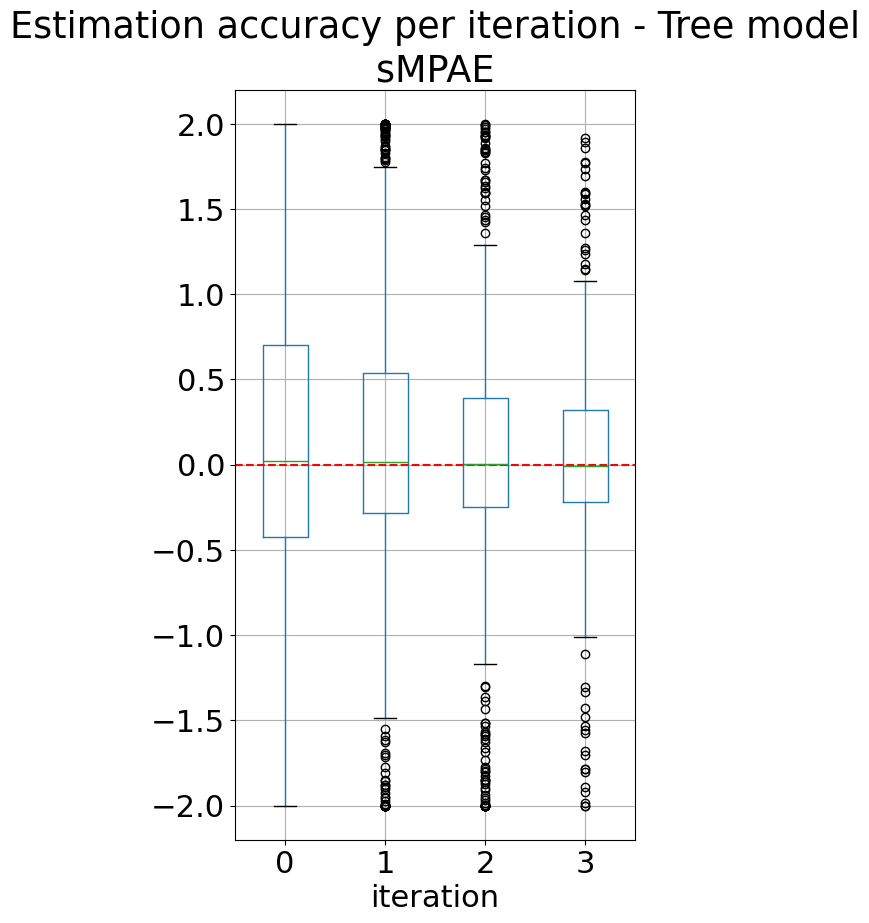

In [27]:
boxplots_per_iteration(iteration_data, "mse", "Tree", "Growing_Window", ["sMPAE"], 10, 5);

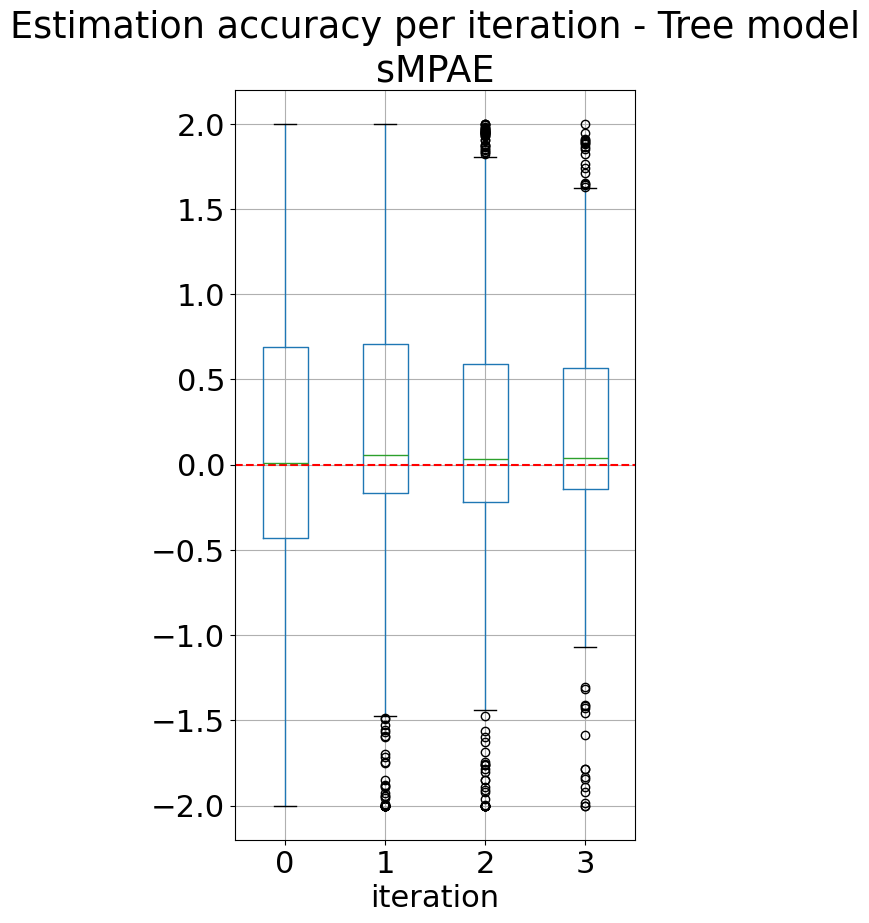

In [28]:
boxplots_per_iteration(iteration_data, "mse", "Tree", "Rolling_Window", ["sMPAE"], 10, 5);

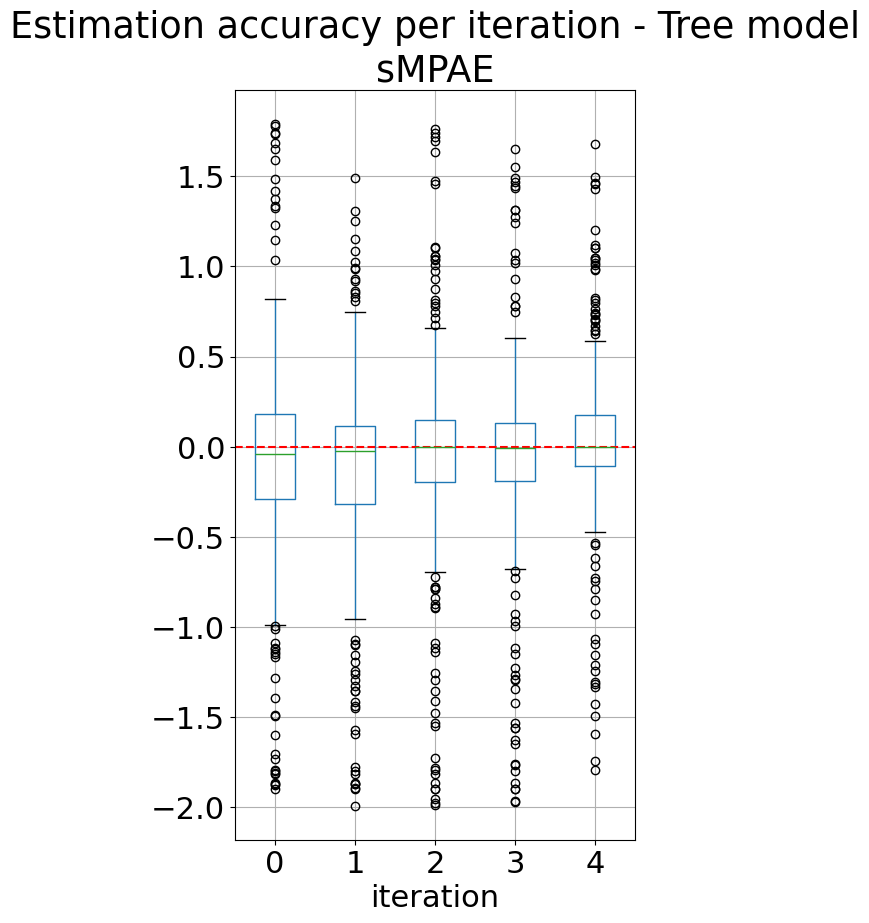

In [29]:
boxplots_per_iteration(iteration_data, "mae", "Tree", "Block_CV", ["sMPAE"], 10, 5);

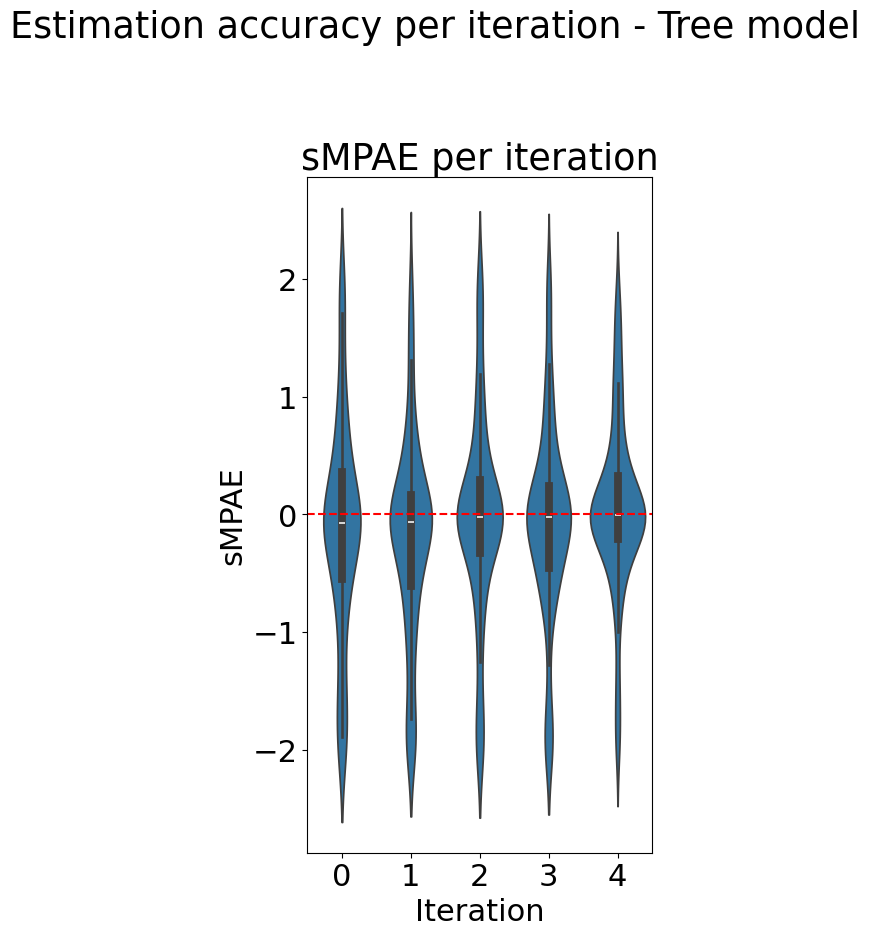

In [30]:
violinplots_per_iteration(iteration_data, "mse", "Tree", "Block_CV", ["sMPAE"], 10, 5);